In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
import torch.nn as nn

import anndata as ad
import cellxgene_census

import pronto
import warnings
warnings.filterwarnings("ignore", category=pronto.warnings.ProntoWarning)


import umap

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
#os.chdir('/home/fujoshua/cell_classification/model_outputs')
os.chdir('/nfs/turbo/umms-welchjd/mccell')

In [3]:
outputs = pd.read_csv('2024-04-08_results.csv')

In [4]:
outputs

,epoch,accuracy_train_leaf_hist,loss_train_hist,loss_train_leaf_hist,loss_train_internal_hist,accuracy_val_leaf_hist,loss_val_hist,loss_val_leaf_hist,loss_val_internal_hist,f1_score_train_leaf,f1_score_val_leaf,f1_score_train_internal,f1_score_val_internal
0,1,62.464016,4.260474,3.970087,0.290387,32.710628,NaN,NaN,0.147584,0.644849,0.572534,0.814154,0.705249


## Accuracy


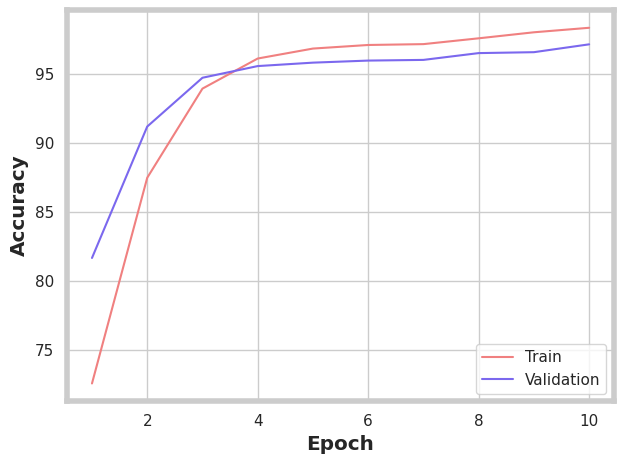

In [12]:

sns.lineplot(data=outputs,x='epoch',y='accuracy_train_leaf_hist', 
                color='lightcoral',label='Train')
sns.lineplot(data=outputs,x='epoch',y='accuracy_val_leaf_hist', 
                color='mediumslateblue',label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

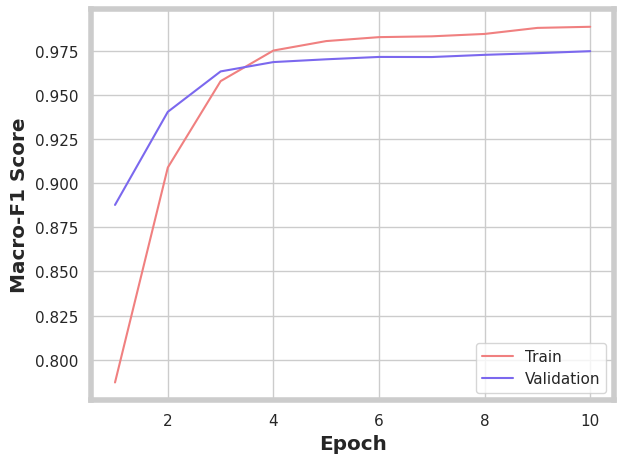

In [14]:
sns.lineplot(data=outputs,x='epoch',y='f1_score_train_leaf', 
                color='lightcoral',label='Train')
sns.lineplot(data=outputs,x='epoch',y='f1_score_val_leaf', 
                color='mediumslateblue',label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Macro-F1 Score')
plt.legend(loc='lower right')
plt.show()

## UMAP the predicted outputs

In [2]:
os.chdir('/home/fujoshua/cell_classification/model_outputs')
targets = torch.load('targets_good_1Dec.pt')#,map_location=torch.device('cpu'))
outputs = torch.load('output_good_1Dec.pt')#,map_location=torch.device('cpu'))

In [3]:
outputs.shape

torch.Size([110413, 85])

In [4]:
fit = umap.UMAP()

Started at 12:00 with 241414 cells and 52 outputs. Finished about 12:57 on CPU
Started at 12:17 with 110413 cell and 85 outputs. Finished about 12:29 on GPU/CPU?

In [6]:
u = fit.fit_transform(outputs.cpu().detach().numpy())


In [7]:
u.shape


(110413, 2)

In [20]:
#u = fit.transform(clf.linear3.weight.detach().numpy())


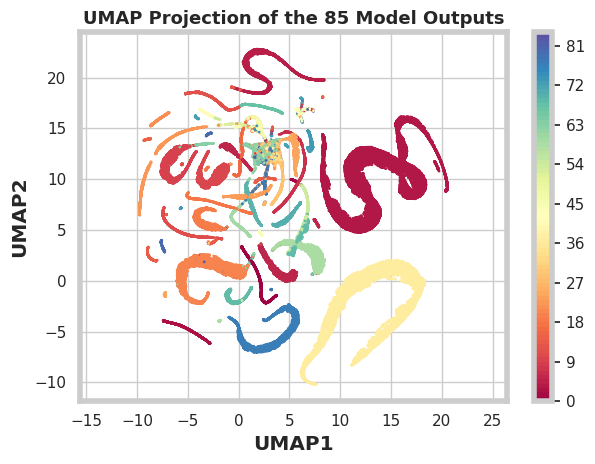

In [9]:
# cmap options tab20c, spectral

plt.scatter(u[:,0],u[:,1],c=targets.cpu().detach(),cmap='Spectral',s=1)
plt.gca().set_aspect('equal', 'datalim')

plt.colorbar(boundaries=np.arange(85))#-0.5)#.set_ticks(np.arange(52))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of the 85 Model Outputs',fontsize=13)


plt.show()


# Plot MetaData from CellCensus on Disk

In [2]:
# gene and cell type info stored on Turbo
os.chdir('/nfs/turbo/umms-welchjd/mccell')

In [5]:
# load the cell type list
# and build the cell metadata value filter
cell_type_list_name = 'cell_type_list.txt'
with open(cell_type_list_name,'rb') as fp:
    cell_type_list = pickle.load(fp)

obs_val_filter = '''assay == "10x 3\' v3" and is_primary_data == True and cell_type_ontology_term_id in {}'''.format(cell_type_list)


In [6]:
census = cellxgene_census.open_soma(uri = "/scratch/welchjd_root/welchjd99/fujoshua/soma")


Now, get the metadata for our search. We can then use this to preprocess everything. 

In [7]:
target_column = ['cell_type_ontology_term_id']


cell_obs_metadata = (
    census["census_data"]["homo_sapiens"].obs.read(value_filter = obs_val_filter,
                                                   column_names=target_column).concat().to_pandas()
    )



In [8]:
cell_obs_metadata

,cell_type_ontology_term_id,assay,is_primary_data
0,CL:0000763,10x 3' v3,True
1,CL:0000763,10x 3' v3,True
2,CL:0000763,10x 3' v3,True
3,CL:0000763,10x 3' v3,True
4,CL:0000542,10x 3' v3,True
...,...,...,...
2726024,CL:0000860,10x 3' v3,True
2726025,CL:0000860,10x 3' v3,True
2726026,CL:0000860,10x 3' v3,True
2726027,CL:0000940,10x 3' v3,True


In [19]:
cell_obs_metadata['cell_type_ontology_term_id'].value_counts()

cell_type_ontology_term_id
CL:0000235    342706
CL:0000129    258406
CL:0000084    180853
CL:0000583    110097
CL:0000625    104457
               ...  
CL:0000771        22
CL:0000844        19
CL:0000808        13
CL:0000893         8
CL:0000841         8
Name: count, Length: 143, dtype: int64

In [21]:
'CL:0002629' in cell_obs_metadata['cell_type_ontology_term_id'].to_list()

False

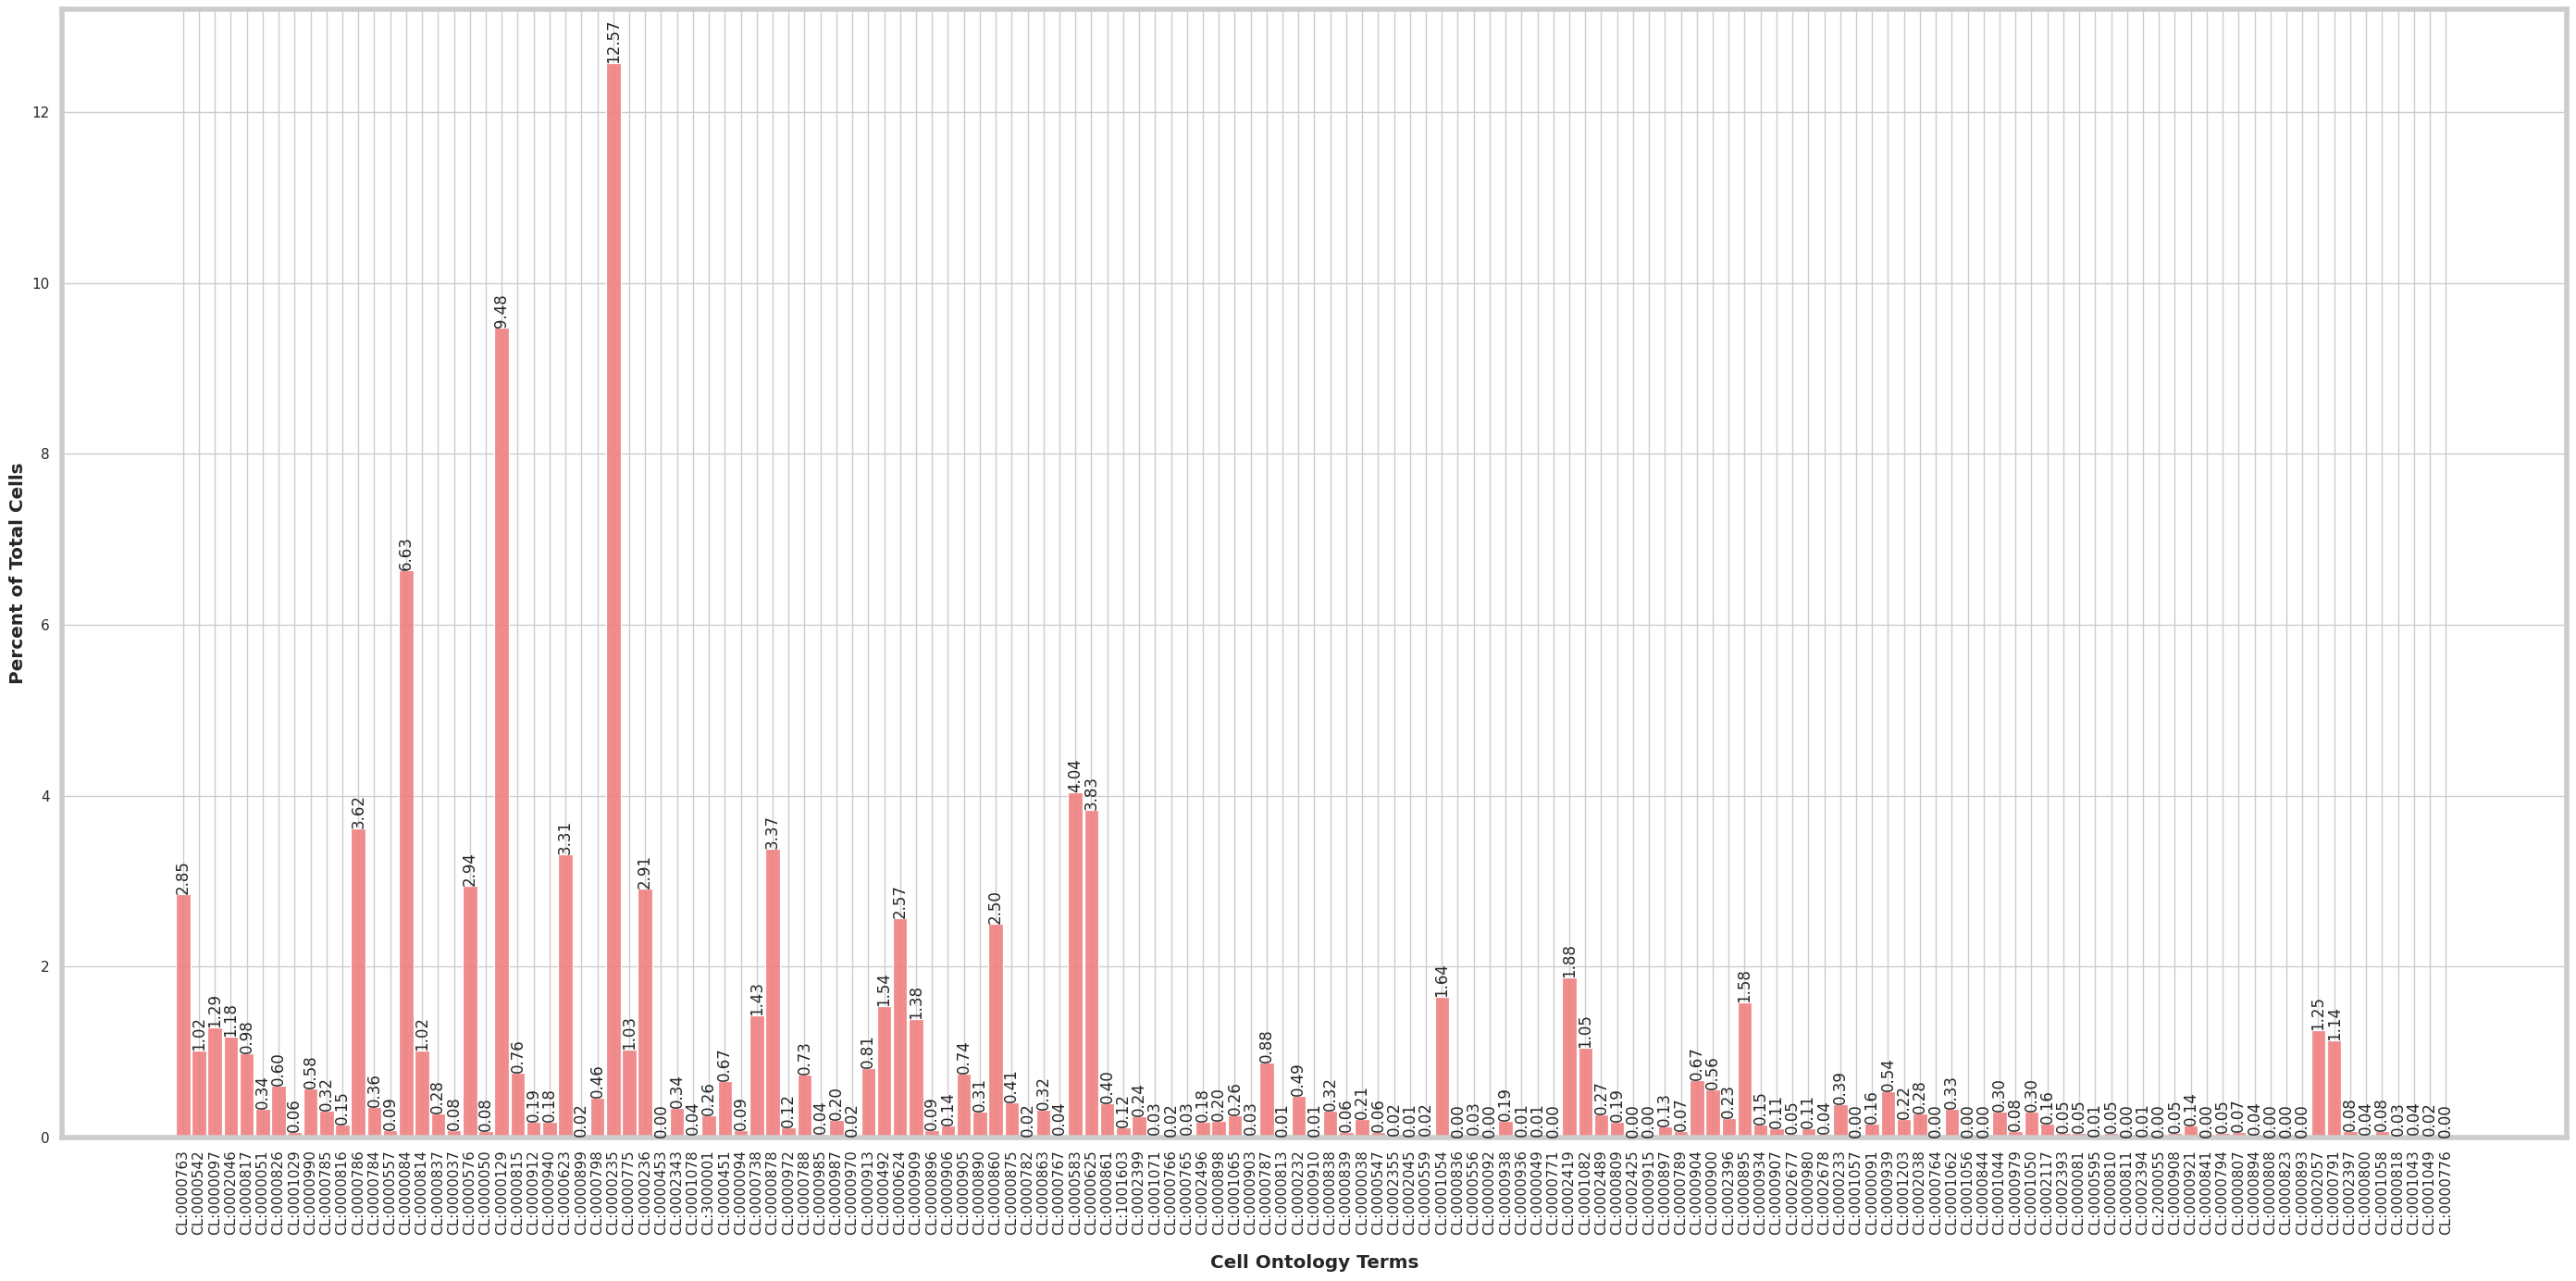

In [17]:
#cell_ids = adata.obs['cell_type_ontology_term_id']

plt.figure(figsize=(28,14))

plots = sns.histplot(x=cell_obs_metadata['cell_type_ontology_term_id'],stat='percent',
                     color='lightcoral',alpha=0.9,shrink=0.9)
# stat can also be probability or percent

plots.bar_label(plots.containers[0],fmt='%.2f',rotation=90)


#plt.xticks(rotation=90)
plt.xlabel('Cell Ontology Terms',labelpad=15)
plt.ylabel('Percent of Total Cells')
plt.xticks(rotation=90)


plt.show()